In [4]:
import arff, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV



In [14]:
columns = ['Project', 'TeamExp', 'ManagerExp', 'YearEnd', 'Length', 'Effort', 'Transactions', 'Entities', 'PointsAjust', 'Envergure', 'PointsNonAdjust', 'Language']
df_desharnais = pd.read_csv('./desharnais.txt', names=columns, comment='%', skipinitialspace=True, delimiter=',')
df_desharnais.head()

print(df_desharnais['TeamExp'].unique())
print(df_desharnais['ManagerExp'].unique())

df_desharnais['TeamExp'] = df_desharnais['TeamExp'].replace('?', np.nan)
df_desharnais['TeamExp'] = pd.to_numeric(df_desharnais['TeamExp'], errors='coerce')
df_desharnais['TeamExp'].fillna(df_desharnais['TeamExp'].median(), inplace=True)

df_desharnais['ManagerExp'] = df_desharnais['ManagerExp'].replace('?', np.nan)
df_desharnais['ManagerExp'] = pd.to_numeric(df_desharnais['ManagerExp'], errors='coerce')
df_desharnais['ManagerExp'].fillna(df_desharnais['ManagerExp'].median(), inplace=True)

['1' '0' '4' '2' '3' '?']
['4' '0' '1' '2' '3' '?' '7' '5']


C:\Users\Vaishali Thakur\AppData\Local\Temp\ipykernel_16928\4176142716.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_desharnais['TeamExp'].fillna(df_desharnais['TeamExp'].median(), inplace=True)
C:\Users\Vaishali Thakur\AppData\Local\Temp\ipykernel_16928\4176142716.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

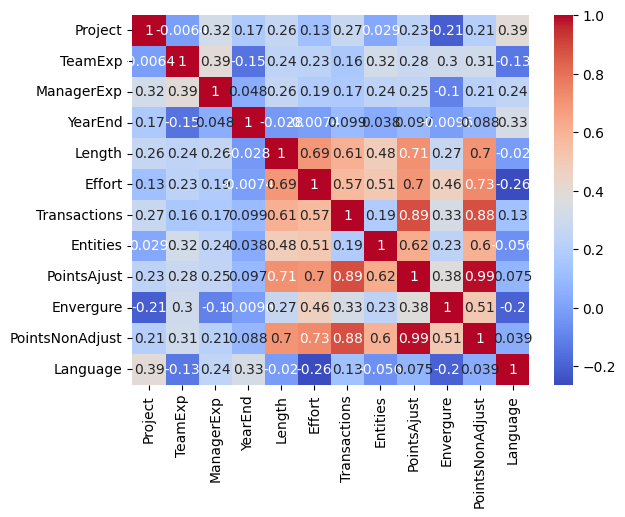

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = df_desharnais.corr()

# Heatmap to visualize correlations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [15]:
#Picked the entitites with more than 0.5 correraltion, however this shows teamexp and manager exp is less correlated
#according to my domain knowledge team exp and manager expereine also matters
features = [ 'TeamExp', 'ManagerExp', 'Length', 'Transactions', 'Entities',
        'PointsNonAdjust',  'PointsAjust']

max_corr_features = ['Length', 'Transactions', 'Entities','PointsNonAdjust','PointsAjust']

X = df_desharnais[features]
Y = df_desharnais['Effort']

# desharnais n_estimator=500 and max_features= 1 to 8

In [16]:

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=42)

In [17]:
MMRE_list=[]
MdMRE_list=[]
Pred_list= []
for i in np.arange(1,9):   
    clf= RandomForestRegressor(n_estimators=500,max_features=i)
    clf.fit(X_train, y_train)
    Y_pred=clf.predict(X_test)
    diff=np.absolute(y_test-Y_pred)
    MRE=diff/y_test
    MMRE=np.mean(MRE)
    MdMRE=np.median(MRE)
    P=MRE[MRE<.25]
    Pred=(P.size/MRE.size) * 100
    MMRE_list.append(MMRE)
    MdMRE_list.append(MdMRE)
    Pred_list.append(Pred)

In [18]:
MMRE_list

[np.float64(0.8354619039993062),
 np.float64(0.8247229513117261),
 np.float64(0.8337696353767697),
 np.float64(0.8287750396335782),
 np.float64(0.8057198724699903),
 np.float64(0.8162882245094382),
 np.float64(0.8237892941283286),
 np.float64(0.8240708640026452)]

In [19]:
MdMRE_list

[np.float64(0.34927606177606174),
 np.float64(0.31633113129644924),
 np.float64(0.3431359177954227),
 np.float64(0.33904997664642694),
 np.float64(0.3322251284446521),
 np.float64(0.30547687996263434),
 np.float64(0.3371106959364783),
 np.float64(0.3374834189631013)]

In [20]:
Pred_list

[36.0,
 32.0,
 28.000000000000004,
 32.0,
 28.000000000000004,
 28.000000000000004,
 32.0,
 28.000000000000004]

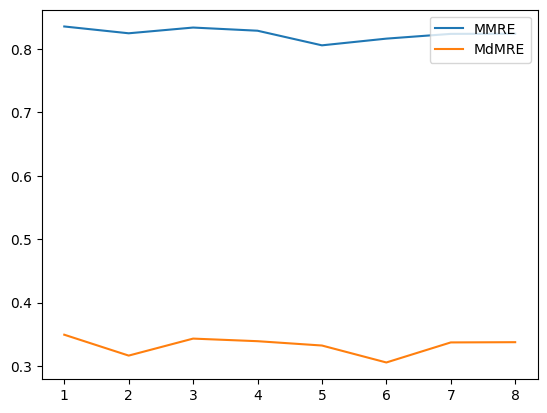

In [21]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1,9)

plt.plot(x, MMRE_list)
plt.plot(x, MdMRE_list)

plt.legend(['MMRE','MdMRE'], loc='upper right')

plt.show()

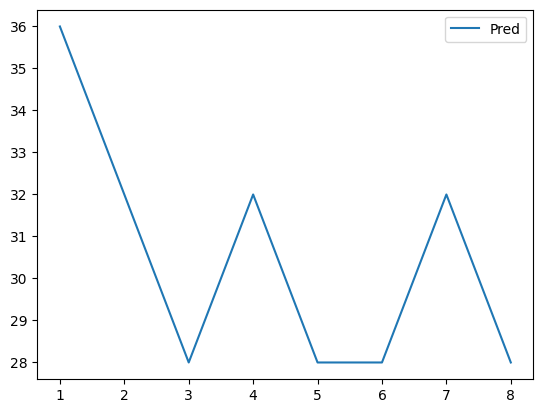

In [22]:
plt.plot(x, Pred_list)
plt.legend(['Pred'], loc='upper right')
plt.show()

# desharnais n_estimator=100 to 1000 and max_features= 5


In [23]:
MMRE_list=[]
MdMRE_list=[]
Pred_list= []
for i in np.arange(100,1100,100):   
    clf= RandomForestRegressor(n_estimators=i,max_features=5)
    clf.fit(X_train, y_train)
    Y_pred=clf.predict(X_test)
    diff=np.absolute(y_test-Y_pred)
    MRE=diff/y_test
    MMRE=np.mean(MRE)
    MdMRE=np.median(MRE)
    P=MRE[MRE<.25]
    Pred=(P.size/MRE.size) * 100
    MMRE_list.append(MMRE)
    MdMRE_list.append(MdMRE)
    Pred_list.append(Pred)

In [24]:
MMRE_list

[np.float64(0.8203014744483115),
 np.float64(0.8104108560892785),
 np.float64(0.8539550574680032),
 np.float64(0.81695471244428),
 np.float64(0.8112865913663646),
 np.float64(0.8200999649188089),
 np.float64(0.8278053969068275),
 np.float64(0.8074472339703804),
 np.float64(0.8181724302549165),
 np.float64(0.8146271450412583)]

In [25]:
MdMRE_list

[np.float64(0.31440915460065383),
 np.float64(0.3363568425969173),
 np.float64(0.361096061030671),
 np.float64(0.34631830920130774),
 np.float64(0.3379420831387202),
 np.float64(0.3346286781877627),
 np.float64(0.32231333822646296),
 np.float64(0.34311361513311533),
 np.float64(0.348640303077482),
 np.float64(0.3517286314806165)]

In [26]:
Pred_list

[36.0,
 28.000000000000004,
 24.0,
 28.000000000000004,
 28.000000000000004,
 28.000000000000004,
 28.000000000000004,
 36.0,
 28.000000000000004,
 24.0]

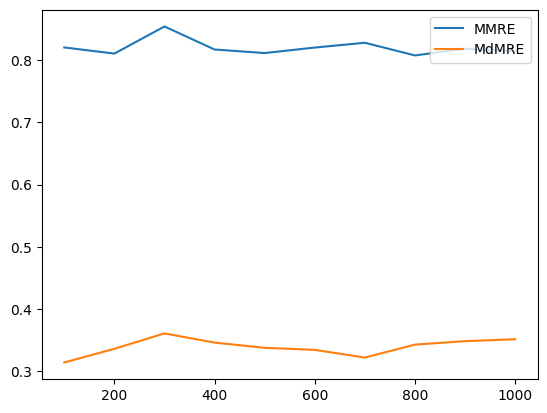

In [27]:
x = np.arange(100,1100,100)
plt.plot(x, MMRE_list)
plt.plot(x, MdMRE_list)

plt.legend(['MMRE','MdMRE'], loc='upper right')

plt.show()

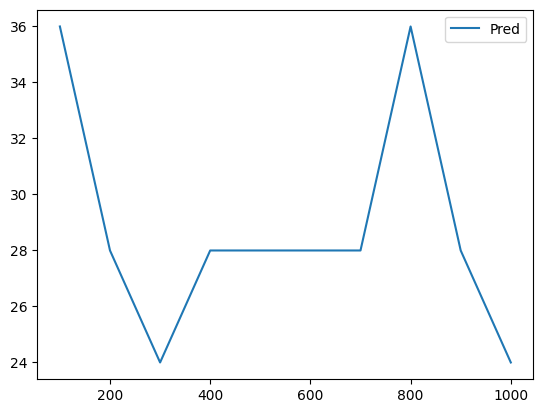

In [28]:
plt.plot(x, Pred_list)
plt.legend(['Pred'], loc='upper right')
plt.show()

# GridSearchCV

In [29]:
params_grd={
 'max_features': [1,2,3,4,5,6,7,8],
  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [30]:
clf= RandomForestRegressor()
grd_search=GridSearchCV(estimator = clf, param_grid = params_grd, 
                          cv = 10, n_jobs = -1, verbose = 2)
grd_search.fit(X_train, y_train)
best_grid = grd_search.best_estimator_

Y_pred=best_grid.predict(X_test)
diff=np.absolute(y_test-Y_pred)
MRE=diff/y_test
MMRE=np.mean(MRE)
MdMRE=np.median(MRE)
P=MRE[MRE<.25]
Pred=(P.size/MRE.size) * 100


Fitting 10 folds for each of 80 candidates, totalling 800 fits


c:\Python310\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [31]:
print(MMRE)
print(MdMRE)
print(Pred)

0.827206977552308
0.3472833333333333
36.0


In [32]:
grd_search.best_params_

{'max_features': 1, 'n_estimators': 1000}


# Random Hyperparameter Grid

In [33]:
Random_grid={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': [1,2,3,4,5,6,7,8],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [34]:
clf= RandomForestRegressor()
random_grd_search=RandomizedSearchCV(estimator = clf, param_distributions = Random_grid, n_iter = 100, cv = 10, 
                              verbose=2, random_state=42, n_jobs = -1)
random_grd_search.fit(X_train, y_train)
best_grid = random_grd_search.best_estimator_

Y_pred=best_grid.predict(X_test)
diff=np.absolute(y_test-Y_pred)
MRE=diff/y_test
MMRE=np.mean(MRE)
MdMRE=np.median(MRE)
P=MRE[MRE<.25]
Pred=(P.size/MRE.size) * 100


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [35]:
print(MMRE)
print(MdMRE)
print(Pred)

0.8229424517760596
0.32109398146346424
40.0


In [36]:
random_grd_search.best_params_

{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 1,
 'max_depth': 80,
 'bootstrap': False}

#  Regression Tree Analysis

In [37]:
clf= DecisionTreeRegressor(max_depth=30, min_samples_split=20)
clf.fit(X_train, y_train)
Y_pred=clf.predict(X_test)
diff=np.absolute(y_test-Y_pred)
MRE=diff/y_test
MMRE=np.mean(MRE)
MdMRE=np.median(MRE)
P=MRE[MRE<.25]
Pred=(P.size/MRE.size) * 100

In [38]:
print(MMRE)
print(MdMRE)
print(Pred)

0.9157740470996295
0.475478748248482
32.0
